# Introduction: Strategy for Maximizing IMDb Score

**Background:** The IMDb 5000 dataset provides information about 5000 movies and their statistics on the IMDb platform. 

**Motivation:** It is common to use a movie's IMDb score to evaluate whether you want to stream or go out to see a movie. If a movie studio is trying to promote their movie on IMDb, can we provide it with a strategy that can maximize the movie's IMDb score?

**Overview of Solution:** This problem assumes new-coming studio movies, so we do not use historical data like a studio's previous movie scores. 
The types of information can be categorizes into 3 groups:


*  **Numerical IMDb data**: score, # user reviews, # critic reviews, etc.
*  **Numerical/Ordinal Movie-Specific data**: budget, gross, year released, director Facebook likes, etc.  
*   **Categorical Movie-Specific data**: country, language, director name, etc. 

Due to the variable formats of the data, this problem presents the challenge of finding an intuitive and robust method to represent the features in the models. 

A linear regression, random forest regression, and gradient boosting machine are evaluated using 3-fold cross-validation for IMDb score predictions. 







# Importing Libraries and Data

In [100]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm


!ln -sTf "/content/drive/My Drive/BA_Assignment" "/content/BA_Assignment"
%cd '/content/BA_Assignment'

imdb_df = pd.read_csv("/content/drive/MyDrive/BA_Assignment/movie_metadata.csv")

/content/drive/My Drive/BA_Assignment


# Data Exploration and Preprocessing

In [101]:
imdb_df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,8,143,NaN,0.0,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b2a149210>,
      dtype=object)

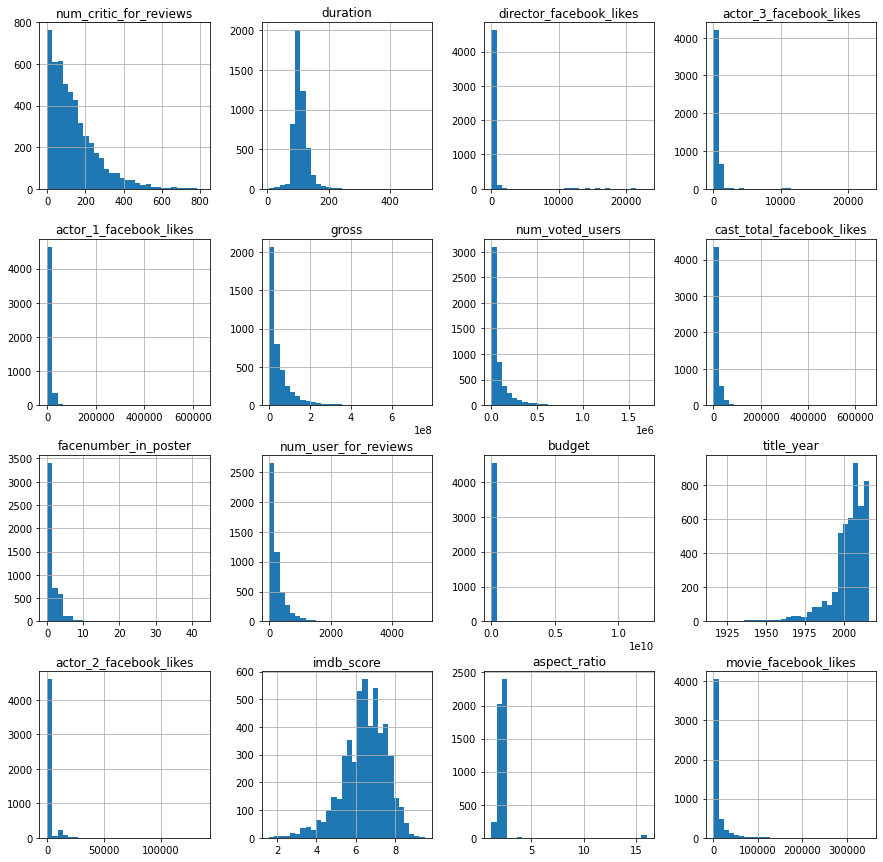

In [102]:
#Looking at a historam for each of the numerical Columns
imdb_df.hist(bins = 30, figsize=(15, 15))

**Observations:**


*   imdb_score is most representative of a normal distribution
*   many features appear right-skewed, the shape indicates the possible existence of outliers (mean greater than the median and mode)



## I: Interpreting Numerical Columns

### Range and Correlation Data

In [103]:
imdb_df.dtypes #Look at the types of our columns


for col in imdb_df.columns: #Look at the range of values in each numerical column
   if imdb_df[col].dtype != object:
     print(col + ':\n ' + ' Range: ' + str(imdb_df[col].max() - imdb_df[col].min()) + ' Average Value: ' + str(imdb_df[col].mean()))

#Noticeably large range for variables - facebook_likes (director, actors 1 - 3, cast total) ; num_voted_users ; gross ; num_user_for_reviews ; budget
#We might consider doing a transformation to avoid large model weights

num_critic_for_reviews:
  Range: 812.0 Average Value: 140.1942719807731
duration:
  Range: 504.0 Average Value: 107.2010739856802
director_facebook_likes:
  Range: 23000.0 Average Value: 686.5092123911724
actor_3_facebook_likes:
  Range: 23000.0 Average Value: 645.0097609561753
actor_1_facebook_likes:
  Range: 640000.0 Average Value: 6560.04706115965
gross:
  Range: 760505685.0 Average Value: 48468407.52680933
num_voted_users:
  Range: 1689759 Average Value: 83668.16081697402
cast_total_facebook_likes:
  Range: 656730 Average Value: 9699.06385088241
facenumber_in_poster:
  Range: 43.0 Average Value: 1.3711729622266402
num_user_for_reviews:
  Range: 5059.0 Average Value: 272.77080844285143
budget:
  Range: 12215499782.0 Average Value: 39752620.436387606
title_year:
  Range: 100.0 Average Value: 2002.4705167173252
actor_2_facebook_likes:
  Range: 137000.0 Average Value: 1651.7544731610337
imdb_score:
  Range: 7.9 Average Value: 6.442137616498111
aspect_ratio:
  Range: 14.82 Average Value

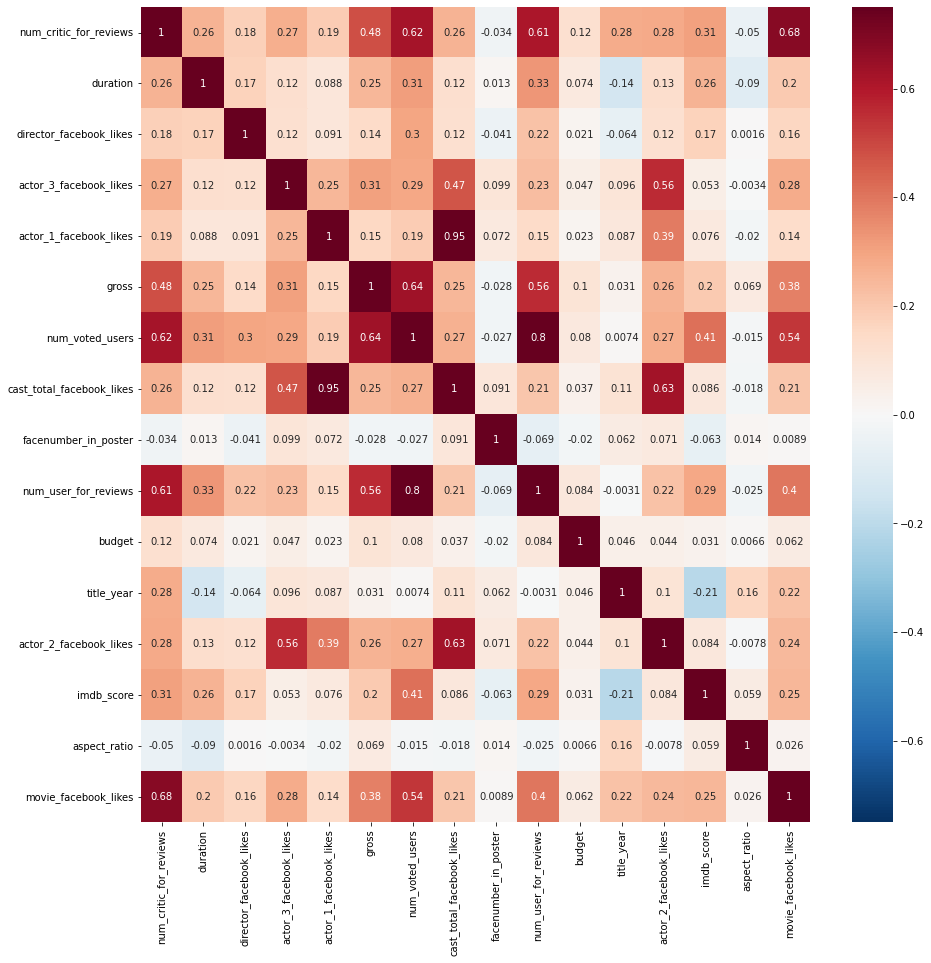

In [104]:
plt.subplots(figsize=(15, 15))
sns.heatmap(imdb_df.corr(), annot=True, vmin=-0.75, vmax=.75, cmap='RdBu_r') #correlation between numerical values, with a threshold looking at >= |.75| corr

### Handling Missing Values

In [105]:
imdb_df.drop_duplicates(inplace=True) #drop duplicate values
imdb_df.shape #Looks like there were 46 duplicates

(4998, 28)

In [106]:
imdb_df.isna().sum() #observing instances of missing values

#Determining how to impute missing data for numerical columns 

#title_year
imdb_df['title_year'].isna().sum()
imdb_df = imdb_df.dropna(axis=0, subset=['title_year'])

In [107]:
#budget
imdb_df.budget.describe()
imdb_df.dropna(axis=0, subset=['budget'], inplace=True)

In [108]:
#aspect_ratio
imdb_df.aspect_ratio.describe()
imdb_df.aspect_ratio.mode().iloc[0]
imdb_df.aspect_ratio.fillna(imdb_df.aspect_ratio.mode().iloc[0], inplace=True)

In [109]:
#facenumber_in_poster    
imdb_df.facenumber_in_poster.unique()
imdb_df.facenumber_in_poster.fillna(imdb_df.facenumber_in_poster.median(), inplace=True)  

In [110]:
#num_critic_for_reviews
imdb_df.num_critic_for_reviews.describe()
imdb_df.num_critic_for_reviews.fillna(imdb_df.num_critic_for_reviews.median(), inplace=True) 

In [111]:
#num_user_for_reviews
imdb_df.num_user_for_reviews.describe()
imdb_df.num_user_for_reviews.fillna(imdb_df.num_critic_for_reviews.median(), inplace=True) 

In [112]:
#duration
imdb_df.duration.describe()
imdb_df.duration.mode().iloc[0]
imdb_df.duration.fillna(imdb_df.duration.mode().iloc[0], inplace=True)

In [113]:
#actor_1_facebook_likes
imdb_df.actor_1_facebook_likes.describe()
imdb_df.actor_1_facebook_likes.fillna(imdb_df.actor_1_facebook_likes.median(), inplace=True) 

In [114]:
#actor_2_facebook_likes
imdb_df.actor_2_facebook_likes.describe()
imdb_df.actor_2_facebook_likes.fillna(imdb_df.actor_2_facebook_likes.median(), inplace=True) 

In [115]:
#actor_3_facebook_likes
imdb_df.actor_3_facebook_likes.describe()
imdb_df.actor_3_facebook_likes.fillna(imdb_df.actor_3_facebook_likes.median(), inplace=True) 

In [116]:
imdb_df.gross.describe()
imdb_df.gross.fillna(imdb_df.gross.median(), inplace=True) 

In [117]:
imdb_df.isna().sum()

color                         14
director_name                  0
num_critic_for_reviews         0
duration                       0
director_facebook_likes        0
actor_3_facebook_likes         0
actor_2_name                   9
actor_1_facebook_likes         0
gross                          0
genres                         0
actor_1_name                   6
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  15
facenumber_in_poster           0
plot_keywords                112
movie_imdb_link                0
num_user_for_reviews           0
language                       9
country                        1
content_rating               202
budget                         0
title_year                     0
actor_2_facebook_likes         0
imdb_score                     0
aspect_ratio                   0
movie_facebook_likes           0
dtype: int64

## II: Interpreting Categorical Columns

In [118]:
for col in imdb_df.columns: #Look at the number of unique values in categorical columns
   if imdb_df[col].dtype == object:
     print(col + ': ' + str(len(imdb_df[col].unique())))

color: 3
director_name: 2174
actor_2_name: 2726
genres: 858
actor_1_name: 1879
movie_title: 4426
actor_3_name: 3181
plot_keywords: 4311
movie_imdb_link: 4427
language: 45
country: 63
content_rating: 16


### Handling Missing Values

In [119]:
#Drop NAs from all categorical rows (Director, Actors, Genres)
#Unlike with our numerical columns, imputing would not be reasonable unless using a model-based method
imdb_df = imdb_df.dropna(axis = 0, subset = ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'language', 'country'])

### Simplifying or Encoding Values

In [120]:
#Color 
imdb_df.color.describe()
(imdb_df['color'].value_counts() / imdb_df['color'].count())*100 
#Over 95% of movies in this dataset are in color, making color a poor predictor variable
imdb_df.drop(columns = 'color', inplace=True)

In [121]:
#Director_Name, the director could be well-known by audiences, we can use the frequency (number of moves in list) as an indicator
imdb_df['director_num_movies'] = imdb_df.director_name.map(imdb_df.director_name.value_counts())

In [122]:
# Same is true of actor_name: Actor 1, 2, 3, replace with count
imdb_df['actor1_num_movies'] = imdb_df.actor_1_name.map(imdb_df.actor_1_name.value_counts())
imdb_df['actor2_num_movies'] = imdb_df.actor_2_name.map(imdb_df.actor_2_name.value_counts())
imdb_df['actor3_num_movies'] = imdb_df.actor_3_name.map(imdb_df.actor_3_name.value_counts())
imdb_df = imdb_df.drop(columns=['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name'])

In [123]:
#Genres 
imdb_df.genres.unique() #Looks like values are a list of genres, leading to a wide range of values 
#Slice, find first genre provided, convert remaining into a count of list of genres 
imdb_df['num_genres'] = imdb_df.genres.apply(lambda x: len(x.split('|')))
imdb_df['genre'] = imdb_df.genres.apply(lambda x: x.split('|')[0] if '|' in x else x)
imdb_df = imdb_df.drop(columns = ['genres']) #drop genres
imdb_df.genre.unique()

array(['Action', 'Adventure', 'Drama', 'Animation', 'Comedy', 'Mystery',
       'Crime', 'Biography', 'Fantasy', 'Documentary', 'Sci-Fi', 'Horror',
       'Romance', 'Family', 'Thriller', 'Western', 'Musical', 'Film-Noir'],
      dtype=object)

Grouping by genre type, we can visualize the mean imdb_score for each. 

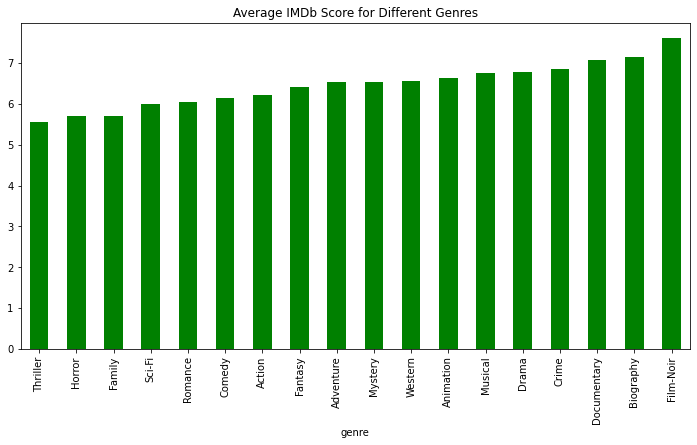

In [132]:
grouped_genre = imdb_df.groupby('genre')
mean_score_genre = grouped_genre['imdb_score'].mean().reset_index()
mean_score_genre.sort_values(['imdb_score', 'genre'], ascending = True, inplace=True)
plt.figure(figsize=(12,6))
plt.title('Average IMDb Score for Different Genres')
mean_score_genre.set_index('genre')['imdb_score'].plot.bar(color='green')

In [124]:
#Language column
imdb_df.language.describe()
(imdb_df['language'].value_counts() / imdb_df['language'].count())*100 
#Over 93% of movies in this dataset are in English, making language a poor predictor variable
imdb_df = imdb_df.drop(columns = 'language')

In [125]:
#Country column
imdb_df.country.describe()
country_freq = (imdb_df['country'].value_counts() / imdb_df['country'].count())*100 
top_5 = country_freq[0:5]
#Our top 5 frequent cover > 90% of data, we can consolidate the other countries into an 'Other_Country' column 
def groupCountry(x):
  if (x not in top_5):
    return 'Other'
  return x

imdb_df['country'] = imdb_df['country'].apply(lambda x: groupCountry(x))
(imdb_df['country'].value_counts() / imdb_df['country'].count())*100 

USA        77.132649
UK          8.329611
Other       7.302367
France      2.880750
Canada      2.367128
Germany     1.987494
Name: country, dtype: float64

Grouping by country, we can visualize the mean IMDb score for each.

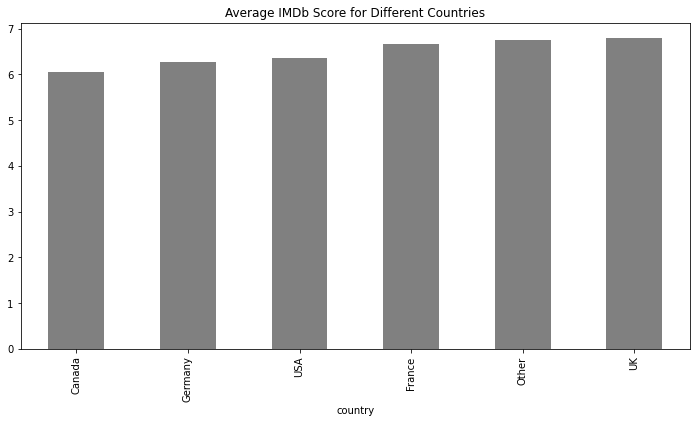

In [134]:
grouped_country = imdb_df.groupby('country')
mean_score_country = grouped_country['imdb_score'].mean().reset_index()
mean_score_country.sort_values(['imdb_score', 'country'], ascending = True, inplace=True)
plt.figure(figsize=(12,6))
plt.title('Average IMDb Score for Different Countries')
mean_score_country.set_index('country')['imdb_score'].plot.bar(color='gray')

In [126]:
#content_rating
imdb_df.content_rating.describe()

#Let's first group by similar age ranges 
#TV-G --> G
imdb_df.content_rating.replace(to_replace= 'TV-G', value = 'G', inplace = True)
#TV-PG, GP --> PG
imdb_df.content_rating.replace(to_replace= ['TV-PG', 'GP'], value = 'PG', inplace = True)
#TV-14 --> PG-13
imdb_df.content_rating.replace(to_replace= ['TV-14', 'PG-13'], value = 'PG13', inplace = True)
#Unrated, Not Rated, Approved, Passed -> Other
imdb_df.content_rating.replace(to_replace= ['Unrated', 'Not Rated', 'Approved', 'Passed'], value = 'Other', inplace = True)
#X, NC-17, M --> R
imdb_df.content_rating.fillna(value='Other', inplace=True)
imdb_df.content_rating.replace(to_replace= ['X', 'NC-17', 'M'], value = 'R', inplace = True)
(imdb_df['content_rating'].value_counts() / imdb_df['content_rating'].count())*100 

R        43.836534
PG13     30.482358
PG       14.716391
Other     8.530594
G         2.434122
Name: content_rating, dtype: float64

Grouping my content rating value, we see that each content rating has a similar mean imdb_score

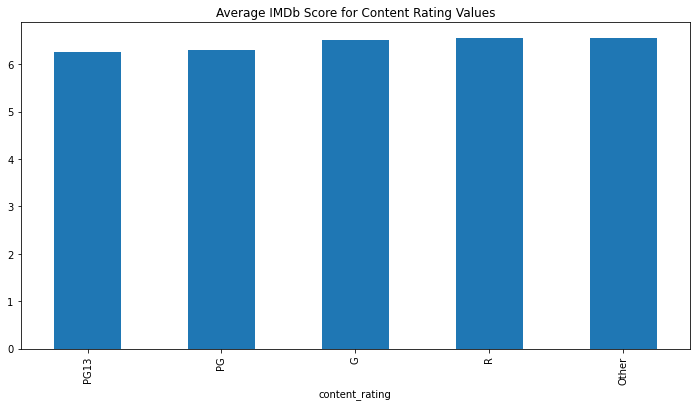

In [130]:
grouped_rating = imdb_df.groupby('content_rating')
mean_score_rating = grouped_rating['imdb_score'].mean().reset_index()
mean_score_rating.sort_values(['imdb_score', 'content_rating'], ascending = True, inplace=True)
plt.figure(figsize=(12,6))
plt.title('Average IMDb Score for Content Rating Values')
mean_score_rating.set_index('content_rating')['imdb_score'].plot.bar()

In [70]:
#Looking at the genre list, and breaking up into a main genre and count of additional
genre_freq = (imdb_df['genre'].value_counts() / imdb_df['genre'].count())*100
top_10 = genre_freq[0:10]
def groupGenre(x):
  if (x not in top_10):
    return 'Other'
  return x

imdb_df['genre'] = imdb_df['genre'].apply(lambda x: groupGenre(x))
(imdb_df['genre'].value_counts() / imdb_df['genre'].count())*100  

Comedy         25.904422
Action         24.251898
Drama          18.356409
Adventure       9.557838
Crime           6.587762
Biography       5.180884
Horror          4.689594
Other           2.032157
Documentary     1.295221
Animation       1.116570
Fantasy         1.027244
Name: genre, dtype: float64

For movie_title, movie_imdb_link, and plot_keywords, we see these features are unique to each entry. Thus, we would not consider them to be strong predictors of imdb_score

In [71]:
#movie_title, very unique to each entry - not a strong predictor variable
(imdb_df['movie_title'].value_counts() / imdb_df['movie_title'].count())*100 
imdb_df.drop(columns='movie_title', inplace=True, axis = 0)

In [72]:
(imdb_df['movie_imdb_link'].value_counts() / imdb_df['movie_imdb_link'].count())*100 
imdb_df.drop(columns='movie_imdb_link', inplace=True, axis = 0)

In [73]:
#plot_keywords: similar to movie title - not a strong predictor variable
(imdb_df['plot_keywords'].value_counts() / imdb_df['plot_keywords'].count())*100  
imdb_df.drop(columns='plot_keywords', inplace=True, axis = 0)

The genre, content_rating, and country features of movies can be one-hot-encoded for use in the model. 

In [74]:
imdb_df = pd.get_dummies(data=imdb_df, columns=['genre', 'content_rating', 'country'])

In [75]:
imdb_df.drop(axis=0, inplace=True, columns=['genre_Other', 'content_rating_Other', 'country_Other'])

# Statistically Modeling imdb_score

Before setting up the models, we break up the columns in the independent variables (X) and our dependent variable of interest, imdb_score (y)

In [76]:
y = imdb_df['imdb_score']
X = imdb_df.drop('imdb_score', axis = 1)

Our histograms from Data Exploration indiciated that the continuous variables were largely right-skewed. Thus, we can apply a Log Transformation.

In [77]:
X = np.log1p(X) #we use log1p, as some variables are 0 and would not be handled correctly with the log function

## I: Train / Test Split and Scaling

We break up our data into train (80%) and test (20%) sets

In [78]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3582, 39), (3582,), (896, 39), (896,))

We can then use a RobustScaler (robust against outliers) to scale the continuous variables in our dataset after splitting into train / test sets.

In [79]:
cols_cont = [col for col in X.columns if 'genre_' not in col and 'content' not in col and 'country' not in col] #columns with continuous data

In [80]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

X_train[cols_cont] = scaler.fit_transform(X_train[cols_cont])
X_test[cols_cont] = scaler.fit_transform(X_test[cols_cont])
X[cols_cont] = scaler.fit_transform(X[cols_cont])

## II: Single Linear Regressions for Continuous Variables

After selecting the independent variables for the model, we can also see how good of a predictor each variable is in a single feature model. First, I'll test the continuous variables and note the R^2, intercept, coefficent and p-value from a single feature regression model. 

In [81]:
for col in cols_cont:
  print('\nimdb_score:' + col)
  f = 'imdb_score~' + col
  model = sm.ols(formula = f, data = imdb_df).fit()
  X_new = pd.DataFrame({col: [X[col].min(), X[col].max()]});
  pred = model.predict(X_new)
  print('R squared: ' + str(model.rsquared) + ' ; Intercept: ' + str(model.params[0]) + ' ; Coefficient: ' + str(model.params[1]) + ' ; P-Value: ' + str(model.pvalues[1]))
  if model.pvalues[1] > .05: 
    print ('p-value > .05')


imdb_score:num_critic_for_reviews
R squared: 0.11644946481617535 ; Intercept: 5.961765892323677 ; Coefficient: 0.0030919406852857653 ; P-Value: 1.6163285388971185e-122

imdb_score:duration
R squared: 0.1259774007566835 ; Intercept: 4.537385110024752 ; Coefficient: 0.017289827498238416 ; P-Value: 4.5016534667412015e-133

imdb_score:director_facebook_likes
R squared: 0.03158786660182655 ; Intercept: 6.368974365621258 ; Coefficient: 6.76107067050116e-05 ; P-Value: 4.232175912351699e-33

imdb_score:actor_3_facebook_likes
R squared: 0.00396241685587273 ; Intercept: 6.391104178381398 ; Coefficient: 4.0741456045506976e-05 ; P-Value: 2.4941087464640738e-05

imdb_score:actor_1_facebook_likes
R squared: 0.006272968321113903 ; Intercept: 6.378542968528703 ; Coefficient: 5.793096373192898e-06 ; P-Value: 1.115105131191312e-07

imdb_score:gross
R squared: 0.03915212508749577 ; Intercept: 6.256427691330606 ; Coefficient: 3.3973238869497117e-09 ; P-Value: 9.095268320592216e-41

imdb_score:num_voted_u

From our OLS, we notice that num_genres is the sole variable with a p-value > 0.05. Thus, we drop num_genres from our model moving forwards

In [82]:
X_train.drop(columns = ['num_genres'], inplace=True, axis = 0)
X_test.drop(columns = ['num_genres'], inplace=True, axis = 0)

## III: Multiple Linear Regressions for Categorical Variables

We can continue to test each of the categorical variables: genre, content rating, and country. As these variables have already been one hot encoded, we can look at the results of the OLS to determine which we should keep in the model. 

In [83]:
cols_genre = [col for col in X.columns if 'genre_' in col]
cols_rating = [col for col in X.columns if 'content' in col]
cols_country = [col for col in X.columns if 'country' in col]

cols = [cols_genre, cols_rating, cols_country]

for col in cols:
    sum_cols = "+".join(col)
    f = "imdb_score ~" + sum_cols
    model = sm.ols(formula= f, data= imdb_df).fit()
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             imdb_score   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     50.65
Date:                Mon, 07 Feb 2022   Prob (F-statistic):           7.59e-97
Time:                        15:01:30   Log-Likelihood:                -6589.1
No. Observations:                4478   AIC:                         1.320e+04
Df Residuals:                    4467   BIC:                         1.327e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.1791      0.11

From the single feature OLS results, we notice that content_rating had the lowest R^2 and can delete it (all corresponding dummy variables) moving forward. The country variable has a low R^2, as well, so we can also drop it from the model.

In [84]:
X_train.drop(columns = cols_rating, inplace=True, axis = 0)
X_test.drop(columns = cols_rating, inplace=True, axis = 0)
X_train.drop(columns = cols_country, inplace=True, axis = 0)
X_test.drop(columns = cols_country, inplace=True, axis = 0)

## IV: Multicollinearity and Recursive Feature Elimination

In [87]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import r2_score as rsquared

reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
adjusted_r_squared = 1 - (1- rsquared(y_test, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
print("Coefficients: \n", reg.coef_)
# The mean squared error
print("Mean squared error: %.3f" % mse(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("RSquared: %.3f" % rsquared(y_test, y_pred))
print ("Adjusted RSquared: %.3f" % adjusted_r_squared)

Coefficients: 
 [ 0.25736001  0.34157347  0.01005421 -0.06015564  0.53511067 -0.04009512
  0.82261571 -0.69320627 -0.03526463 -0.34764713 -0.39819534 -0.16810971
  0.03965854  0.01937528  0.12348967  0.06647439  0.18473047  0.04935276
  0.0313959  -0.090232    0.4573702   1.2273796   0.84920296  0.05710082
  0.42859023  1.67509213  0.5674609  -0.19751107 -0.75336548]
Mean squared error: 0.716
RSquared: 0.397
Adjusted RSquared: 0.392


In [88]:
from sklearn.model_selection import cross_val_score
def cross_validate(X, y):
  score = cross_val_score(reg, X, y, cv = 5, scoring = "r2")
  print("RSquared Mean Score: ", score.mean())
  print(score)

cross_validate(X, y)

RSquared Mean Score:  0.41260502578853275
[0.41134774 0.49305726 0.49292037 0.41136702 0.25433274]


The results of our 5-fold cross-validation are alright, but we notice that our MSE is rather high at .7 and our RSquared is just .38. We may still have issues with dimensionality, so we can explore a new model using feature selection to remove features that may be a source of noise in this initial model. We will first remove highly correlated features and then use SKLearn's RFE to identify the 20 most important features for imdb_score

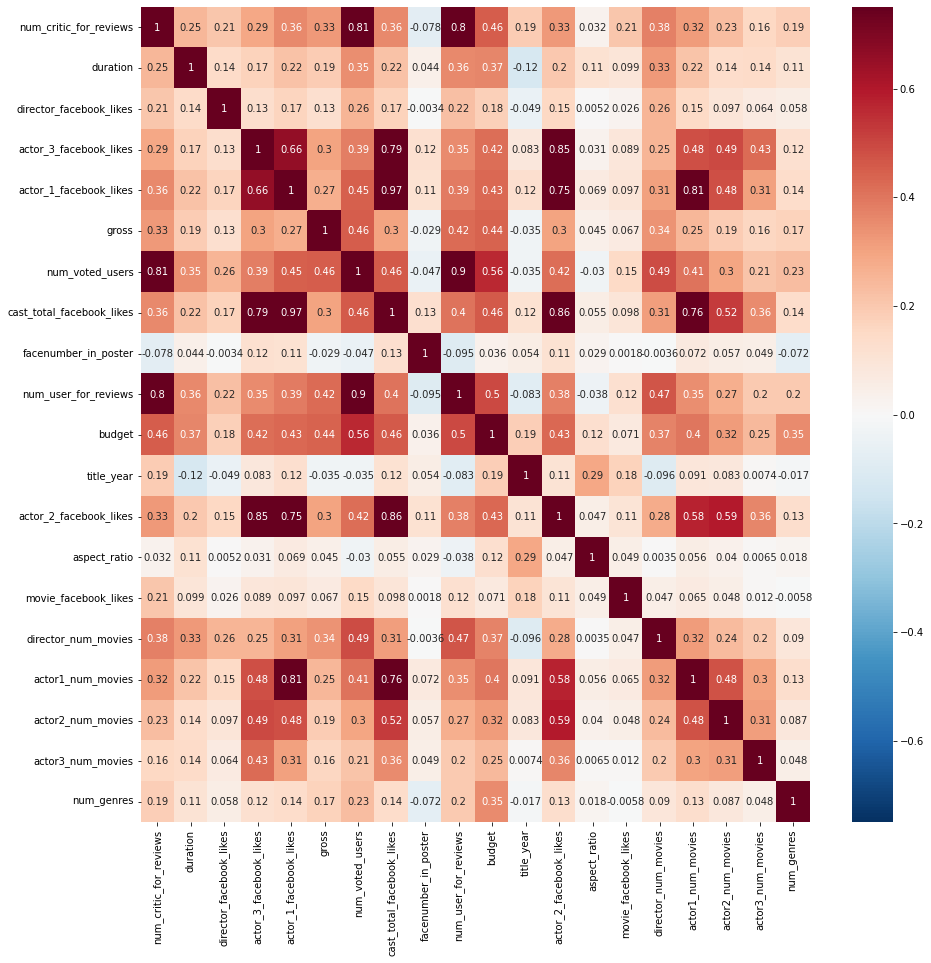

In [92]:
plt.subplots(figsize=(15, 15))
sns.heatmap(X[cols_cont].corr(), annot=True, vmin=-0.75, vmax=.75, cmap='RdBu_r') #correlation between numerical values, with a threshold looking at >= |.75| corr

We can notice several correlated features: cast_total_facebook_likes and num_user_for_reviews contain the highest correlations

In [93]:
X_train.drop(columns = 'cast_total_facebook_likes', inplace=True)
X_test.drop(columns = 'cast_total_facebook_likes', inplace=True)

In [94]:
X_train.drop(columns = 'num_user_for_reviews', inplace=True)
X_test.drop(columns = 'num_user_for_reviews', inplace=True)

We then run RFE to select the 20 most important features

In [95]:
from sklearn.feature_selection import RFE 

selector = RFE(reg, n_features_to_select = 20)
selector = selector.fit(X_train, y_train)

Below, we can see whether the RFE classified the feature to be in the 20 most important. 

In [96]:
list(zip(X_train.columns,selector.support_,selector.ranking_))

[('num_critic_for_reviews', True, 1),
 ('duration', True, 1),
 ('director_facebook_likes', False, 7),
 ('actor_3_facebook_likes', True, 1),
 ('actor_1_facebook_likes', True, 1),
 ('gross', False, 2),
 ('num_voted_users', True, 1),
 ('facenumber_in_poster', False, 6),
 ('budget', True, 1),
 ('title_year', True, 1),
 ('actor_2_facebook_likes', False, 8),
 ('aspect_ratio', False, 5),
 ('movie_facebook_likes', True, 1),
 ('director_num_movies', True, 1),
 ('actor1_num_movies', True, 1),
 ('actor2_num_movies', False, 3),
 ('actor3_num_movies', False, 4),
 ('genre_Action', True, 1),
 ('genre_Adventure', True, 1),
 ('genre_Animation', True, 1),
 ('genre_Biography', True, 1),
 ('genre_Comedy', True, 1),
 ('genre_Crime', True, 1),
 ('genre_Documentary', True, 1),
 ('genre_Drama', True, 1),
 ('genre_Fantasy', True, 1),
 ('genre_Horror', True, 1)]

In [ ]:
col_rfe = X_train.columns[selector.support_] #Top 20 Features selected through RFE

In [ ]:
X_train_rfe = X_train[col_rfe] #new features in training dataframe, containing only selected features

In [ ]:
X_test_rfe = X_test[col_rfe] #new features in testing dataframe, containing only selected features

## V: Linear Regression, Reduced Features

In [ ]:
reg2 = LinearRegression()
reg2.fit(X_train_rfe, y_train)

y_pred = reg2.predict(X_test_rfe)
print("Coefficients: \n", reg.coef_)
# The mean squared error
lin_reg_mse = mse(y_test, y_pred)
lin_reg_rs = rsquared(y_test, y_pred)
print("Mean squared error: %.2f" % lin_reg_mse)
# The Rsquared, coefficient of determination: 
print("RSquared: %.2f" % lin_reg_rs)

Coefficients: 
 [ 1.81181470e-01  3.08005218e-01  1.88345779e-02 -1.47291053e-01
 -1.30168047e-01 -5.75855627e-02  5.87461963e-01 -3.80223948e-02
 -3.92271154e-01 -1.54751106e-01  7.26243772e-04  4.90089296e-02
  1.46385030e-01  7.94512678e-02  2.82548520e-01  2.85887035e-02
  2.86661074e-02 -1.63523129e-01  4.83902777e-01  1.06095024e+00
  8.09632200e-01 -1.14751096e-03  4.33647974e-01  1.73098932e+00
  5.16819124e-01 -2.46972646e-01 -8.45738586e-01]
Mean squared error: 0.73
RSquared: 0.35


We observe that the r2 score for the Multiple Regression Model is low of about 35%. We can try out more advanced ensemble models to help the model fit the data correctly. 

## VI: Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators = 500)
rf_regressor.fit(X_train_rfe, y_train)
rf_pred = rf_regressor.predict(X_test_rfe)
print ('R-Squared: ' + str(rsquared(y_test, y_pred)))
print ('MSE: ' + str(mse(rf_pred, y_test)))

R-Squared: 0.3510047188970945
MSE: 0.5955428907142852


### Hyperparameter Tuning

In [ ]:
from pprint import pprint
pprint(rf_regressor.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


We will try adjusting the following set of hyperparameters: 
n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf, and bootstrap

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {
    'bootstrap' : [True, False],
    'max_depth' : [10, 40, 70, 100],
    'max_features' : [.33, .5], 
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [8, 10],
    'n_estimators' : [100, 500, 1000]
}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 40, 70, 100],
 'max_features': [0.33, 0.5],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [8, 10],
 'n_estimators': [100, 500, 1000]}


In [ ]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions= random_grid, n_iter = 100, cv = 3, verbose = 2, n_jobs = -1)
rf_random.fit(X_train_rfe, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'bootstrap': False,
 'max_depth': 100,
 'max_features': 0.33,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 500}

Using Random Search, we narrowed down a range for each hyperparameter. We can now concentrate our search by using GridSearchCV to evaluate the combinations we define. The following is another grid based on the best values from random search: 

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [90, 100],
    'max_features': [5, 6],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [8, 9],
    'n_estimators': [250, 500, 750]
}
# Create a RF model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search_rf.fit(X_train_rfe, y_train)
grid_search_rf.best_params_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


{'bootstrap': False,
 'max_depth': 90,
 'max_features': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 750}

Using GridSearch, we find the optimal values for the hyperparameters and get a MSE of .5732 and RSquared of .4884

In [ ]:
y_grid_pred_rf = grid_search_rf.predict(X_test_rfe)
rf_mse = mse(y_grid_pred_rf, y_test.values)
print('Random Forest MSE: ' + str(rf_mse))
rf_rs = rsquared(y_test.values, y_grid_pred_rf)
print('RSquared: ' + str(rf_rs))

Random Forest MSE: 0.57323856993495
RSquared: 0.48842990576209866


## VII: Gradient Boosting

In [ ]:
from sklearn import ensemble
n_trees=200
gradientboost = ensemble.GradientBoostingRegressor(loss='squared_error',learning_rate=0.03,n_estimators=n_trees,max_depth=4)
gradientboost.fit(X_train_rfe,y_train)

GradientBoostingRegressor(learning_rate=0.03, max_depth=4, n_estimators=200)

In [ ]:
y_pred_gb=gradientboost.predict(X_test_rfe)
error=gradientboost.loss_(y_test,y_pred_gb) #Loss = Mean square error
print("GBM MSE: %.3f" % error)
print("GBM RSquared: %.3f" % rsquared(y_test.values, y_pred_gb))

GBM MSE: 0.590
GBM RSquared: 0.473


### Hyperparameter Tuning

We are looking to tune the following hyperparameters of the GBM: learning_rate, n_estimators, and max_depth

In [ ]:
gb_random_grid = {
    'loss' : ['squared_error'],
    'max_depth' : [1, 3, 5, 7, 9], 
    'learning_rate' : [0.001, 0.01, 0.1, 1],
    'n_estimators' : [100, 500, 1000]
}

gb = ensemble.GradientBoostingRegressor()
gb_random = RandomizedSearchCV(estimator = gb, param_distributions= gb_random_grid, cv = 3, verbose = 2, n_jobs = -1)
gb_random.fit(X_train_rfe, y_train)
gb_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


{'learning_rate': 0.01,
 'loss': 'squared_error',
 'max_depth': 5,
 'n_estimators': 1000}

Using Random Search, we narrowed down a range for each hyperparameter. We can now concentrate our search by using GridSearchCV to evaluate the combinations we define. The following is another grid based on the best values from random search: 

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'loss' : ['squared_error'],
    'max_depth' : [4, 5, 6],
    'learning_rate' : [.01, .02, .03],
    'n_estimators': [750, 1000, 1250]
}
# Create a based model
gb = ensemble.GradientBoostingRegressor()
# Instantiate the grid search model
grid_search_gb = GridSearchCV(estimator = gb, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search_gb.fit(X_train_rfe, y_train)
grid_search_gb.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


{'learning_rate': 0.01,
 'loss': 'squared_error',
 'max_depth': 5,
 'n_estimators': 750}

Using GridSearch, we find the optimal values for the hyperparameters and get a MSE of .594 and RSquared of .470

In [ ]:
grid_search_gb_pred = grid_search_gb.predict(X_test_rfe)
gb_mse = mse(y_test.values, grid_search_gb_pred)
gb_rs = rsquared(y_test.values, grid_search_gb_pred)
print("GBM MSE: %.3f" % gb_mse)
print("GBM RSquared: %.3f" % gb_rs)

GBM MSE: 0.594
GBM RSquared: 0.470


##VIII: Model Comparison and Feature Importance

In [ ]:
model_eval_cols = ['Model', 'MSE', 'RSquared']
model_eval = pd.DataFrame(columns = model_eval_cols)
model_eval = model_eval.append({'Model': 'Linear Regression', 'MSE': lin_reg_mse, 'RSquared': lin_reg_rs}, ignore_index=True)
model_eval = model_eval.append({'Model': 'Random Forest', 'MSE': rf_mse, 'RSquared': rf_rs}, ignore_index=True)
model_eval = model_eval.append({'Model': 'Gradient Boost', 'MSE': gb_mse, 'RSquared': gb_rs}, ignore_index=True)

model_eval

,Model,MSE,RSquared
0,Linear Regression,0.727230,0.351005
1,Random Forest,0.573239,0.488430
2,Gradient Boost,0.593966,0.469932


After evaluating the Linear Regression, Random Forest Regression, and Gradient Booster models, we get the feature importance from our best Random Forest estimator.

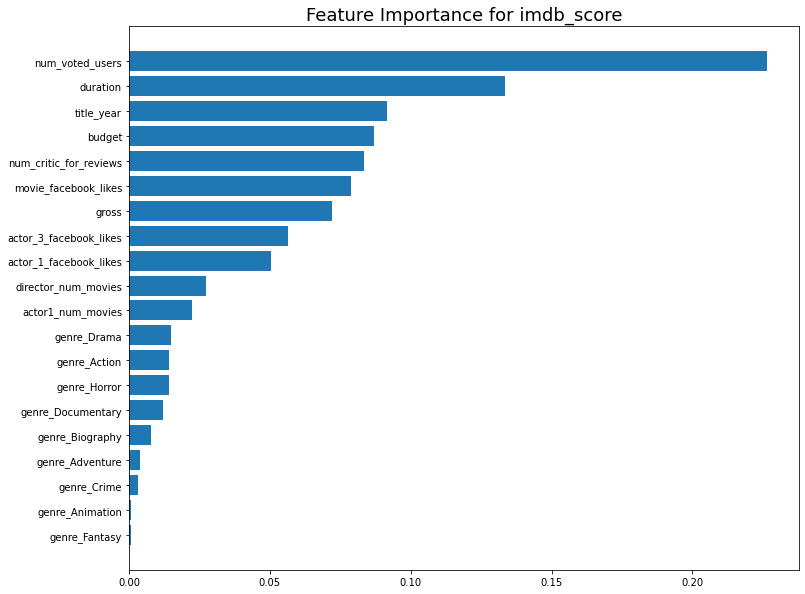

In [ ]:
feature_importance = grid_search_rf.best_estimator_.feature_importances_ #selecting our best estimator from the Random Forest model
sorted_importance = np.argsort(feature_importance) #sorting features by importance
pos = np.arange(len(sorted_importance))
plt.figure(figsize=(12,10))
plt.barh(pos, feature_importance[sorted_importance],align='center')
plt.yticks(pos, X_train_rfe.columns[sorted_importance],fontsize=10)
plt.title('Feature Importance for imdb_score',fontsize=18)
plt.show()

# Conclusion and Takeaways



1.  **Feature Importance:** As displayed above, we can identify the importance of the Top 20 Predictors of imdb_score. The top 5 most prominenta are (in order) : Number of Voted Users, Duration, Title Year, Budget, and the Number of Critic for Reviews
2.   **Model Accuracy**: The most accurate estimator was a Random Forest Regressor with an R^2 of 0.488 and a MSE of 0.573

**Areas for Improvement**


*   **Missing Value Imputation:** More robust NaN imputation for both numerical and categorical variables technique such as KNN or Random Forest Imputation 
*   **Further Model Exploration:** Alternative modeling methods could have been explored including Support Vector Machines and the ensemble model, XGBoost 
*  **Inaccurate Genre Labeling:** Given the genre list, I parsed for the first genre listed and converted the remaining into a count of additional genres. As I'm not sure how the genres were initially ordered, it's possible that some specificity was lost by choosing only the first element. 

**Future Directions**


*   The 'Gross' Column could be evaluated as a dependent variable, and it could be interesting to explore the relationship between the non-IMDB values (director, actor, budget, etc) and the Gross value of movies
*   The 'Content_Rating' label is intriguing, as the industry standards for content rating have changed over time. For example, some movies produced before the MPAA System was established in 1968 could just qualify as "Passed." As the content rating can be understood as a limitation on the expected age range of a movie, I wonder if it could have been converted into an Ordinal variable and further factored more accurately into the prediction model








